
# Practica 1.Perceptron Multicapa

Hernandez Martinez Mally Samira | Código: 220286113 | Ingenieria de computacion (INCO) 

Seminario de Solucion de Problemas de Inteligencia Artificial II | Seccion D05 I7041


1.	Preprocesamiento de Datos:

    - Descargar y cargar la base de datos MNIST, el archivo tiene por nombre train.csv (42000 imágenes separadas en filas de vectores de 784 pixeles, es decir, imágenes de 28x28).

    - Descargar y cargar el archivo de validación el cual tiene de nombre test.csv

    - Normalizar los datos para mejorar la convergencia de la red.


In [1]:
# Importacion de librerías
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import time

# Desactivar advertencias
warnings.filterwarnings('ignore')

# Fijar una semilla para reproducibilidad
np.random.seed(10)

In [2]:
# Mostrar los archivos de la carpeta 'MNIST'
for dirname, _, filenames in os.walk('MNIST'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Cargar los datos
df_train = pd.read_csv('MNIST/train.csv')
df_test = pd.read_csv('MNIST/test.csv')

# Mostrar el tamaño de los datasets
print("Tamaño del dataset de entrenamiento:", df_train.shape)
print("Tamaño del dataset de prueba:", df_test.shape)
print(f"-----------------------------------------------------")

# Mostrar las primeras filas del conjunto de entrenamiento
df_train.head()

MNIST\test.csv
MNIST\train.csv
Tamaño del dataset de entrenamiento: (42000, 785)
Tamaño del dataset de prueba: (28000, 784)
-----------------------------------------------------


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Separar las etiquetas de las imágenes
x = df_train.drop(columns='label')
y = df_train['label']

# Normalizar los datos dividiendo por 255
x = x / 255.0
x_test = df_test / 255.0

# Dividir el conjunto de entrenamiento en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

# Convertir las etiquetas a formato categórico (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

# Mostrar el tamaño de los conjuntos
print("Tamaño de x_train:", x_train.shape)
print("Tamaño de x_val:", x_val.shape)
print("Tamaño de y_train (one-hot):", y_train.shape)
print("Tamaño de y_val (one-hot):", y_val.shape)

Tamaño de x_train: (29400, 784)
Tamaño de x_val: (12600, 784)
Tamaño de y_train (one-hot): (29400, 10)
Tamaño de y_val (one-hot): (12600, 10)


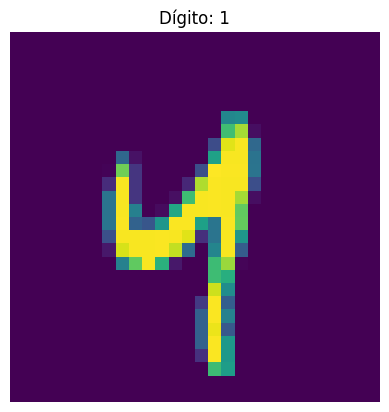

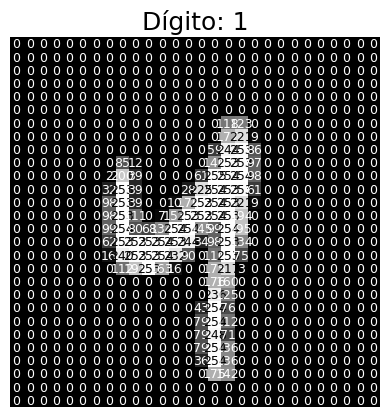

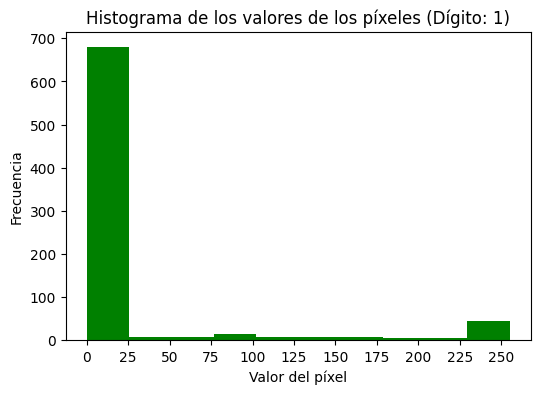

In [4]:
# Mostrar la imagen del primer dígito del conjunto de entrenamiento
plt.imshow(x_train.to_numpy()[0].reshape(28,28))
plt.title(f"Dígito: {y.iloc[0]}")  # Se usa la etiqueta original antes de la conversión a one-hot
plt.axis("off")
plt.show()

# Obtener el primer dígito de x_train y su correspondiente etiqueta
first_image = x_train.iloc[0].to_numpy().reshape(28, 28) * 255  # Se multiplica por 255 para volver a los valores originales
first_label = y.iloc[0]  # Obtener la etiqueta original directamente del DataFrame antes del one-hot

#plt.figure(figsize=(9, 9))
plt.imshow(first_image, cmap='gray')  # Mostrar la imagen en escala de grises
plt.title(f"Dígito: {first_label}", fontsize=18)
plt.axis("off")

# Añadir los valores de los píxeles en cada celda
for i in range(28):
    for j in range(28):
        pixel_value = int(first_image[i, j])  # Convertir a entero
        text_color = 'black' if pixel_value > 200 else 'white'
        plt.text(j, i, str(pixel_value), ha='center', va='center', color=text_color, 
                 fontsize=9, bbox=dict(facecolor='none', edgecolor='none'))

plt.show()

# Mostrar un histograma de los valores de los píxeles
plt.figure(figsize=(6, 4))
# Reducimos los bins para aumentar el grosor de las barras
plt.hist(first_image.flatten(), bins=10, color='Green', alpha=1.0) 
plt.title(f"Histograma de los valores de los píxeles (Dígito: {first_label})")
plt.xlabel('Valor del píxel')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(0, 256, 25)) 
plt.show()


2.	Definición del Modelo:

    - Crear una red MLP utilizando Keras, con múltiples capas ocultas y una capa de salida con 10 neuronas (correspondiente a los dígitos del 0 al 9).

    - Utilizar funciones de activación como ReLU en las capas ocultas y softmax en la capa de salida.

3.	Prueba de optimizadores:

    - Entrenar el modelo con diferentes optimizadores como SGD, Adam, Nadam, RMSprop, Adadelta.

    - Analizar cómo cada optimizador afecta el rendimiento del modelo.

4.	Ajuste de Hiperparámetros:

    - Variar el número de capas ocultas, neuronas por capa, tasa de aprendizaje y épocas de entrenamiento.

In [5]:
# Parámetros para el número de neuronas por capa
hidden_layers = [128, 64]  # Ajusta esta lista para modificar las capas ocultas

# Definir el modelo MLP con flexibilidad en capas ocultas
def crear_modelo(hidden_layers):
    model = keras.Sequential()
    # Agregar capas ocultas dinámicamente
    model.add(keras.layers.Dense(hidden_layers[0], activation='relu', input_shape=(784,)))
    for neurons in hidden_layers[1:]:
        model.add(keras.layers.Dense(neurons, activation='relu'))
    # Capa de salida con 10 neuronas y softmax
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

# Lista de optimizadores con tasa de aprendizaje ajustable
optimizers = {
    'SGD': keras.optimizers.SGD(learning_rate=0.01),  
    'Adam': keras.optimizers.Adam(learning_rate=0.001),  
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'Nadam': keras.optimizers.Nadam(learning_rate=0.001),
    'Adadelta': keras.optimizers.Adadelta(learning_rate=1.0)
}

# Diccionario para almacenar los historiales de entrenamiento de cada optimizador
histories = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nEntrenando con optimizador '{opt_name}'...")

    # Crear una nueva instancia del modelo para cada optimizador
    model = crear_modelo(hidden_layers)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenamos el modelo
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=10, batch_size=32, verbose=1)  # verbose=1 para mostrar cada epoch
    
    # Guardar el historial de entrenamiento para este optimizador
    histories[opt_name] = history


Entrenando con optimizador 'SGD'...
Epoch 1/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5993 - loss: 1.3836 - val_accuracy: 0.8840 - val_loss: 0.4233
Epoch 2/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8932 - loss: 0.3803 - val_accuracy: 0.9048 - val_loss: 0.3284
Epoch 3/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9105 - loss: 0.3137 - val_accuracy: 0.9154 - val_loss: 0.2917
Epoch 4/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9210 - loss: 0.2682 - val_accuracy: 0.9246 - val_loss: 0.2630
Epoch 5/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9297 - loss: 0.2452 - val_accuracy: 0.9311 - val_loss: 0.2425
Epoch 6/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9381 - loss: 0.2172 - val_accuracy: 0.9343 - val_loss: 0.2288
Epoch 7/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9403 - loss: 0.2062 - val_accuracy: 0.9399 - val_loss: 0.2124
Epoch 8/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9

In [6]:
# Mostrar los resultados de cada optimizador

for opt_name, history in histories.items():
    print(f"------------------------------------------")
    print(f'Resultados para optimizador "{opt_name}":')
    print(f"------------------------------------------")
    print(f"Precision en el entrenamiento: {history.history['accuracy'][-1]:.4f}")
    print(f"Precision en la validacion: {history.history['val_accuracy'][-1]:.4f}")
print(f"------------------------------------------")

------------------------------------------
Resultados para optimizador "SGD":
------------------------------------------
Precision en el entrenamiento: 0.9534
Precision en la validacion: 0.9475
------------------------------------------
Resultados para optimizador "Adam":
------------------------------------------
Precision en el entrenamiento: 0.9932
Precision en la validacion: 0.9705
------------------------------------------
Resultados para optimizador "RMSprop":
------------------------------------------
Precision en el entrenamiento: 0.9939
Precision en la validacion: 0.9722
------------------------------------------
Resultados para optimizador "Nadam":
------------------------------------------
Precision en el entrenamiento: 0.9935
Precision en la validacion: 0.9647
------------------------------------------
Resultados para optimizador "Adadelta":
------------------------------------------
Precision en el entrenamiento: 0.9952
Precision en la validacion: 0.9737
------------------

5.	Evaluación y Métricas:

    - Evaluar el modelo utilizando métricas como precisión, recall, F1-score, y pérdida.

    - Presentar la matriz de confusión.

    - Graficar la evolución de la precisión y la pérdida durante el entrenamiento y validación.

In [7]:
# Evaluar en el conjunto de validación
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicciones del modelo en clases

# Verificar las dimensiones de y_val y y_pred_classes
print("Dimensiones de y_pred_classes:", y_pred_classes.shape)
print("Dimensiones de y_val (antes de argmax):", y_val.shape)


# Asegúrate de convertir y_val de one-hot encoding a etiquetas originales
y_true = np.argmax(y_val, axis=1)  # Etiquetas verdaderas (one-hot to class index)

# Verificar las dimensiones de y_true
print("Dimensiones de y_true:", y_true.shape)
print(f"-------------------------------------------------------")


# Reporte de Clasificación (precisión, recall, F1-score)
print("Reporte de Clasificación para cada clase:")
print(f"-------------------------------------------------------")

print(classification_report(y_true, y_pred_classes))

394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Dimensiones de y_pred_classes: (12600,)
Dimensiones de y_val (antes de argmax): (12600, 10)
Dimensiones de y_true: (12600,)
-------------------------------------------------------
Reporte de Clasificación para cada clase:
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1200
           1       0.97      0.99      0.98      1389
           2       0.97      0.97      0.97      1294
           3       0.97      0.96      0.96      1355
           4       0.97      0.97      0.97      1222
           5       0.96      0.97      0.97      1085
           6       0.98      0.98      0.98      1256
           7       0.97      0.97      0.97      1359
           8       0.97      0.97      0.97      1209
           9       0.97      0.97      0.97      1231

    accuracy                           0.97     12600
   macro avg       0.97      0.

In [8]:
# Predecir en los datos de validación
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Generando matriz de confusión ... 


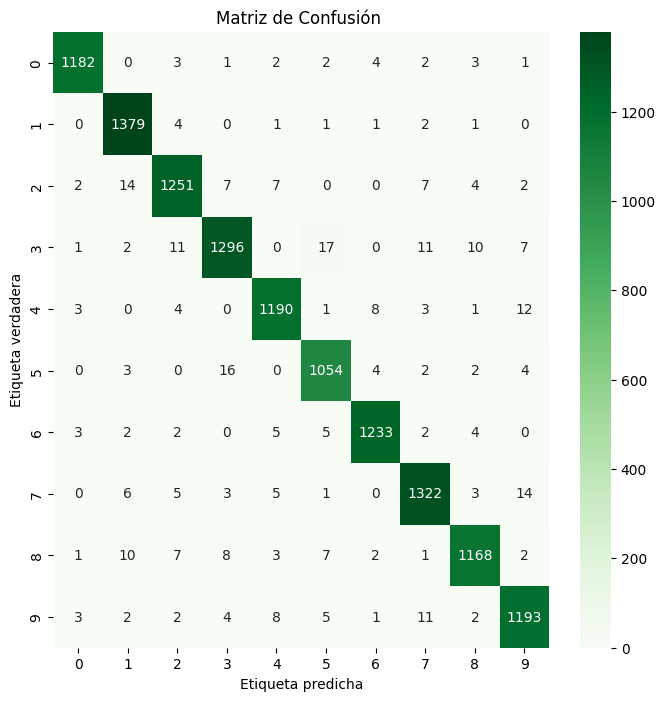

In [9]:
# Generar la matriz de confusión
print(f"Generando matriz de confusión ... ")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
# Graficar la matriz de confusión
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title(f'Matriz de Confusión ')
plt.show()

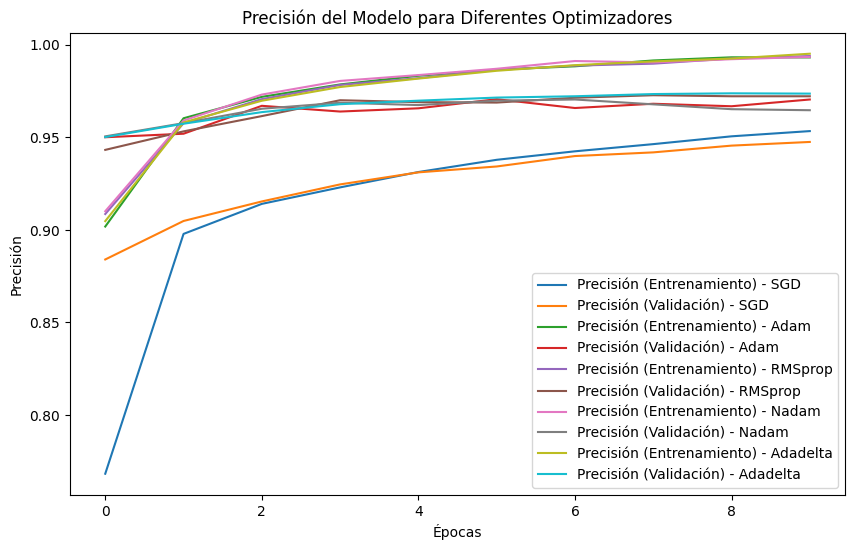

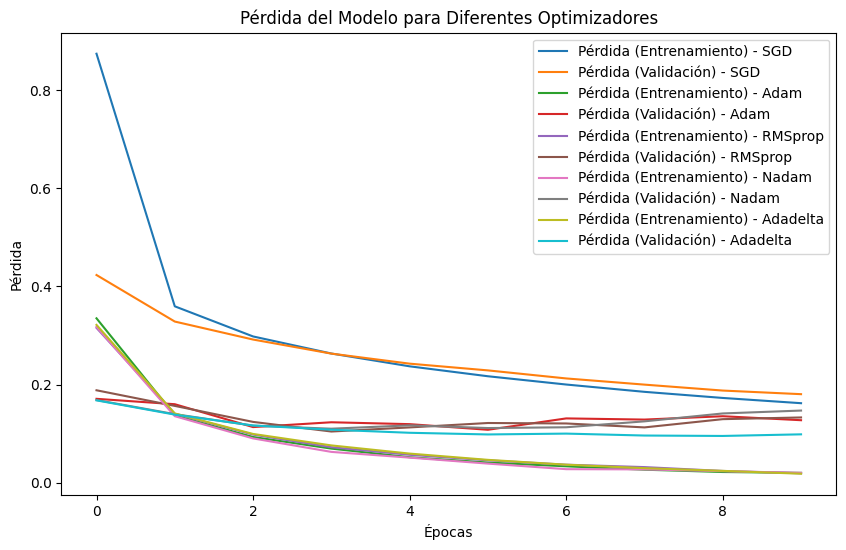

In [10]:
# Graficar la precisión de todos los optimizadores
plt.figure(figsize=(10, 6))
for opt_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'Precisión (Entrenamiento) - {opt_name}')
    plt.plot(history.history['val_accuracy'], label=f'Precisión (Validación) - {opt_name}')
plt.title('Precisión del Modelo para Diferentes Optimizadores')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de todos los optimizadores
plt.figure(figsize=(10, 6))
for opt_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'Pérdida (Entrenamiento) - {opt_name}')
    plt.plot(history.history['val_loss'], label=f'Pérdida (Validación) - {opt_name}')
plt.title('Pérdida del Modelo para Diferentes Optimizadores')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()